# How to build Multi-Armed Bandit Product Recommender
> In e-commerce and other digital domains, companies frequently want to offer personalised product recommendations to users. This is hard when you don’t yet know a lot about the customer, or you don’t understand what features of a product are pertinent. Thinking about it as a multi-armed bandit problem is a useful way to get around this. In this tutorial, we will learn how multi-armed bandit algorithms can be applied to the challenge of product recommendation and then explain how to solve it in code.

- toc: true
- badges: false
- comments: true
- categories: [MultiArmedBandit, Retail]
- image:

## Introduction

Duration: 5

In e-commerce and other digital domains, companies frequently want to offer personalised product recommendations to users. This is hard when you don’t yet know a lot about the customer, or you don’t understand what features of a product are pertinent. Thinking about it as a multi-armed bandit problem is a useful way to get around this. In this tutorial, we will learn how multi-armed bandit algorithms can be applied to the challenge of product recommendation and then explain how to solve it in code.

Multi-armed bandit algorithms can:

- recommend products with the highest expected value while still exploring other products.
- do not suffer from the cold-start problem and therefore don’t require customer preferences or information about products.
- take into account the limitations of how much data you have as well as the cost of gathering data (the opportunity cost of sub-optimal recommendations).

### What you'll learn?

- Build multi-armed bandit models in python
- Compare the model performance

### Why is this important?

- Infuse intelligence in recommender models
- Automatically adapt to the changing environment

### How it will work?

### Who is this for?

- People who are interested in applying reinforcement learning techniques in recommender systems

### Important resources

- [Colab notebook](https://colab.research.google.com/gist/sparsh-ai/86c0daeeb4449c1325577fcbae4c4342/recostep-tutorial-multi-armed-bandit-product-recommender.ipynb)

<!-- ------------------------ -->

## Bandit class

Duration: 2

First of all, we define the base class. In this, we initialize with pay-off probabilities in a list format and define a sample method that will provide the reward for the action taken. The agent do not know these pay-off values and the goal for that agent is to find these pay-offs by exploring and exploiting the environment. For example, if pay-off probability is 90%, we will get a reward of 1 most often and in this manner, the agent will get an idea of this secret pay-off. 

```python
class Bandit:
    """A useful class containing the multi-armed bandit and all its actions.
    
    Attributes:
        actions The actions that can be performed, numbered automatically 0, 1, 2...
        payoff_probs    The underlying pay-off probabilities for each action.
    """

    def __init__(self, payoff_probs):
        self.actions = range(len(payoff_probs))
        self.pay_offs = payoff_probs

    def sample(self, action):
        """Sample from the multi-armed by performing an action.
        
        Args:
            action (int): The action performed on the multi-armed bandit.

        Returns:
            int: It returns a reward based on that arm's pay-off probability.
        """
        selector = random.random()
        return 1 if selector <= self.pay_offs[action] else 0
```

<!-- ------------------------ -->

## Random agent

Duration: 2

Random agent is our baseline. This agnt will randomly pick an action and get the reward for that action. Our hypothesis is that, this will be the worst performing agent.

```python
def random_agent(bandit, iterations):
    """Randomly select an action and reward."""

    for i in range(iterations):
        a = random.choice(bandit.actions)
        r = bandit.sample(a)
        yield a, r
```

<!-- ------------------------ -->

## Optimal agent

Duration: 2

This one is out benchmark. In this, we will expose the hidden pay-off values so that the agent will always take the best possible action and get the maximum probable reward.

```python
def optimal_agent(bandit, iterations):
    """Select the best action by taking a sneak-peek at the bandit's probabilities."""

    for i in range(iterations):
        a = bandit.pay_offs.index(max(bandit.pay_offs))
        r = bandit.sample(a)
        yield a, r
```

<!-- ------------------------ -->

## Explore than exploit agent

Duration: 2

This agent first explore the environment for N rounds and then start taking the action which gave maximum reward during exploration. 

```python
def initial_explore_agent(bandit, iterations, initial_rounds = 10):
    """Initially explore initial_rounds times and then stick to the best action."""
    pay_offs = dict()
    best_action = -1

    for i in range(iterations):
        # for the initial rounds pick a random action
        if i < initial_rounds:
            a = random.choice(bandit.actions)
            r = bandit.sample(a)

            #update rewards
            if a in pay_offs:
                pay_offs[a].append(r)
            else:
                pay_offs[a] = [r]
        # otherwise pick the best one thus far
        else:
            if (best_action == -1):
                # check for the lever with the best average payoff
                mean_dict = {}
                for key,val in pay_offs.items():
                    mean_dict[key] = np.mean(val) 
                best_action = max(mean_dict, key=mean_dict.get)
            a = best_action

            r = bandit.sample(a)
        
        yield a, r
```

<!-- ------------------------ -->

## Epsilon greedy agent

Duration: 2

This agent always explore the environment with a probability of epsilon, which is 20% in our case. This means, out of 5, this agent will recommend the highest-probability reward product 4 times and recommend a random product 1 time. 

```python
def epsilon_greedy_agent(bandit, iterations, epsilon = 0.2, initial_rounds = 1):
    """Use the epsilon-greedy algorithm by performing the action with the best average
    pay-off with the probability (1-epsilon), otherwise pick a random action to keep exploring."""

    pay_offs = dict()

    for i in range(iterations):
        # sometimes randomly pick an action to explore
        if random.random() < epsilon or i < initial_rounds:
            a = random.choice(bandit.actions)
        # otherwise pick the best one thus far
        else:
            # check for the lever with the best average payoff
            new_dict = {}
            for key,val in pay_offs.items():
                new_dict[key] = np.mean(val) 
            a = max(new_dict, key=new_dict.get)

        r = bandit.sample(a)

        #update rewards
        if a in pay_offs:
            pay_offs[a].append(r)
        else:
            pay_offs[a] = [r]
        
        yield a, r
```

<!-- ------------------------ -->

## Decaying epsilon greedy agent

Duration: 2

This agent will initially take random actions with epsilon probability but this epsilon keep decaying so that, at the begininng, agent wil recommend 1 random product out of 5, but over time, this will ultimately become zero, and agent will recommend all 5 products with highest possible reward probability.

```python
def decaying_epsilon_greedy_agent(bandit, iterations, epsilon = 0.2, initial_rounds = 1, decay = 0.999):

    pay_offs = dict()

    for i in range(iterations):
        # sometimes randomly pick an action
        if random.random() < epsilon or i < initial_rounds:
            a = random.choice(bandit.actions)
        # otherwise pick the best one thus far
        else:
            # check for the lever with the best average payoff
            new_dict = {}
            for key,val in pay_offs.items():
                new_dict[key] = np.mean(val) 
            a = max(new_dict, key=new_dict.get)

        r = bandit.sample(a)

        #update rewards
        if a in pay_offs:
            pay_offs[a].append(r)
        else:
            pay_offs[a] = [r]
        
        epsilon *= decay

        yield a, r
```

<!-- ------------------------ -->

## Simulation

Duration: 2

We are creating 7 arms. These arms can be compared to 7 products in recommendation domain. These pay-offs represent the buying probability let's say. That means, there is a 25% probability that custom will buy first product and 50% probability of buying third product. And interestingly, no chance of buying last product.

1000 trials is just to smoothen-out the results. 200 iterations means we will recommend the given 7 items to that customer 200 times. The selection of this item-to-be-recommended would depend on the agent.

```python
random.seed(200) #used for reproducibility

pay_offs = [0.25, 0.3, 0.5, 0.1, 0.3, 0.25, 0]
bandit = Bandit(pay_offs)

methods = [random_agent, initial_explore_agent, epsilon_greedy_agent, decaying_epsilon_greedy_agent, optimal_agent]

number_of_iterations = 200
number_of_trials = 1000

for m in range(len(methods)):
    method = methods[m]
    total_rewards = []

    list_of_cumulative_rewards = []
    fan = []

    for trial in range(number_of_trials):
        total_reward = 0
        cumulative_reward = []

        for a, r in method(bandit, number_of_iterations):
            total_reward += r
            cumulative_reward.append(total_reward)

        #plt.plot(cumulative_reward, alpha=.02, color=colors[m])
        total_rewards.append(total_reward)

        if trial == 0:
            fan = pd.DataFrame(cumulative_reward, columns=['y'])
            fan['x'] = fan.index+1
        else:
            fan2 = pd.DataFrame(cumulative_reward, columns=['y'])
            fan2['x'] = fan2.index+1

            fan = fan.append(fan2, ignore_index=True)

        list_of_cumulative_rewards.append(cumulative_reward)

    sns.lineplot(x='x', y='y', data=fan)  #default is to use bootstrap to calculate confidence interval     
    
    print(method.__name__, ":", np.mean(total_rewards))

plt.title("Cumulative reward for each algorithm over {} iterations with {} trials.".format(number_of_iterations, number_of_trials))
plt.ylabel("Cumulative reward")
plt.xlabel("Iterations")
plt.legend([method.__name__ for method in methods])

f.savefig("Iterations.pdf", bbox_inches='tight')
f.savefig("Iterations.svg", bbox_inches='tight')

plt.show()
```

As expected, random agent performed worst and optimal agent performed best. Epsilon greedy and its decaying version performed equally well and it is better than explore-than-exploit method.

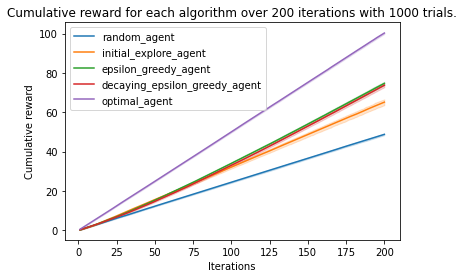

## Conclusion

Duration: 2

Congratulations!

### What we've covered

- Built various MAB models: random, optimal, explore-than-exploit, epsilon-greedy, decaying-epsilon-greedy
- Simulation and plotting

### Next steps

- Learn the methods in depth
- Tune hyperparameters
- Thompson sampling method

### Links and References

- [How to Build a Product Recommender Using Multi-Armed Bandit Algorithms](https://www.offerzen.com/blog/how-to-build-a-product-recommender-using-multi-armed-bandit-algorithms)